### Objectives:
  * 1) Calculate the average hours per day that all Americans travel.
  * 2) Observe the weekly cycles, if any, in reasons for travel.
  * 3) Try to discern whether homes are closer to work or school, perhaps giving insight into housing market choices.

### Data Source:
Data from the Bureau of Labor Statistics' ATUS - the American Time-Use Survey.  
ATUS is itself is a sub-sampling of respondents previously surveyed in the CPS -  
Current Population Survey, a monthly survey to maintain knowledge of labor statistics.  
https://www.kaggle.com/bls/american-time-use-survey

ATUS provides 9 linkable datasets. (more on that later). One is a summary.
The full datasets, especially when merged need 4Gb of memory, so can cripple my laptop.  
Thus I choose to prototype my code with pruned down versions of each csv file.  

I will start with the summary: "atussum.csv"  
It being *totals* of activity times, it is wider than the other cvs's (455 columns) but not so deep.

N.B. for readability variable name abreviations:
  * fp:   for... File Path  
  * df:   for... Data Frame   
  * se:   for... Series  

<span style="color:green">NB that notes in green are "magic carpet moments",   
where, in draft #1, I fly over the gaps/omissions/holes,   
for the sake of getting to the end of the first draft,  
in the blind faith that, in draft #2+, I can fix them. </span>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib                       # python3.4+ depreciated imp.reload. Use importlib.reload
import atus_var_dictionary as avd      # my way to get a grip of col/var meanings
importlib.reload(avd)                  # comment out when no longer making changes to atus_var_dictionary
%matplotlib inline

In [3]:
# file paths to initial csv files
data_dir= '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/'

sum_fp  = os.path.join(data_dir, 'atussum.csv')  #0.2 Gb
act_fp  = os.path.join(data_dir, 'atusact.csv')  #0.4 Gb
resp_fp = os.path.join(data_dir, 'atusresp.csv') #0.1 Gb
rost_fp = os.path.join(data_dir, 'atusrost.csv')
cps_fp  = os.path.join(data_dir, 'atuscps.csv')  #0.6 Gb
who_fp  = os.path.join(data_dir, 'atuswho.csv')

# file paths to intermediate csv files
travel_sum_fp   = os.path.join(data_dir, 'tw_atus_travel_sum.csv')
travel_act_fp   = os.path.join(data_dir, 'tw_atus_travel_act.csv')
travel_cps_fp   = os.path.join(data_dir, 'tw_atus_travel_cps.csv')
travel_resp_fp  = os.path.join(data_dir, 'tw_atus_travel_resp.csv')
travel_all_fp   = os.path.join(data_dir, 'tw_atus_travel_all.csv')

In [4]:
# As data files were large, these flags determine whether:
#     1) to read original cvs file, prune un-needed data and save intermediate to disk
#     2) to read the pruned intermediate cvs from disk
force_prune_sum_csv = False
force_prune_activities_csv = False
force_prune_cps_csv = False
force_prune_resp_csv = False

In [5]:
# The vast majority of the summary's columns and coded activities, for now, I shall discard:
# Keeping the first 24 columns that interest me and all columns related to travel.

# NB I save the data-reduced result for faster re-use later.
if (not os.path.exists(travel_sum_fp)) or force_prune_sum_csv:
    df_sum = pd.read_csv(sum_fp)
    big_shape = df_sum.shape
    first_24 = list(df_sum.columns.values)[:24]
    travel_18s = list(df_sum.filter(regex='t18', axis=1))
    first24_and_travel = first_24 + travel_18s
    df_sum = df_sum.filter(items=first24_and_travel)
    lean_travel_shape = df_sum.shape

    print("#summary rows reduced from {0} to {1}".format(big_shape[0],df_sum.shape[0]))
    print("#summary cols reduced from {0} to {1}".format(big_shape[1],df_sum.shape[1]))
    print("writing out a csv file for summary data to help isolate, school run, commute and students...")
    df_sum.to_csv(path_or_buf=travel_sum_fp, mode = 'w', index=False)

    print("\nAlso in the summary data, we have {0} recorded reasons for travel.".format(len(travel_18s)))
else:
    df_sum = pd.read_csv(travel_sum_fp)

###  Recall Objective 1:

  * 1) Calculate the average hours per day that all Americans travel.

Before diving into different, specific reasons for travel, let's sum *ALL* travel columns,   
whatever they represent and make a new column "all_travel" to hold that sum.  

In [6]:
# Summing across columns ( hence: axis = 1) all those named in the list: travel_18s
travel_18s = list(df_sum.filter(regex='t18', axis=1))
df_sum['all_travel'] = df_sum[travel_18s].sum(axis=1)

In [7]:
# The average time spent traveling by Americans:
all_travelling_any_reason = df_sum['all_travel'].sum()
all_travellers = df_sum['all_travel'].count()
mean_travel_any_reason = round(all_travelling_any_reason / all_travellers)
in_hours = mean_travel_any_reason/60
print("\nAverage time Americans spend traveling = {0:.0f} mins".format(mean_travel_any_reason))
print("(ie {0:.2f} hours ... Travelling for any reason.)\n".format(in_hours))


Average time Americans spend traveling = 72 mins
(ie 1.20 hours ... Travelling for any reason.)



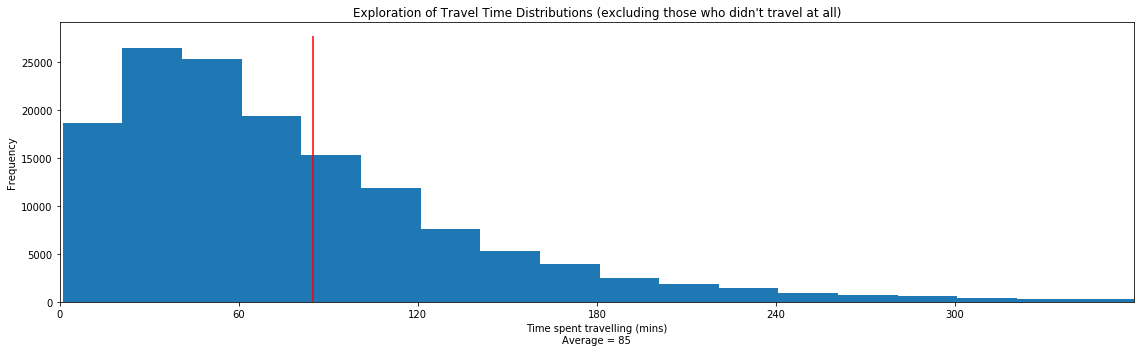

Presumably the right-skew from including those that "travel" for a living; taxi, truck, bus drivers etc
This is just the 'Summary data'. I need to press on... however, if I were to circle back...
I'd remove those professionals by merging data including 'occupation'.
(NB. There are 1902 trips lasting longer than 6 hours clipped away.)


In [8]:
# Let's plot that new "all_travel" column.
travel_mean = df_sum['all_travel'].mean()
some_travel_mean = df_sum['all_travel'].where(df_sum['all_travel'] > 0).mean()
exclude_stay_at_homes = df_sum['all_travel'].where(df_sum['all_travel'] > 0)
more_than_6_hours = df_sum['all_travel'].where(df_sum['all_travel'] > 360).count()

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1, 1, 1)            # Create second matplotlib axes
exclude_stay_at_homes.plot(kind='hist', ax = ax1, bins=72)
plt.title("Exploration of Travel Time Distributions (excluding those who didn't travel at all)")
plt.xlabel('Time spent travelling (mins)\nAverage = {0:.0f}'.format(some_travel_mean))
plt.ylabel('Frequency')
plt.xlim([0, 360])
ymin, ymax = plt.ylim()
plt.xticks(range(0, 360, 60))
plt.vlines(some_travel_mean, 0, ymax, color='red')
plt.tight_layout()
plt.show()

print('Presumably the right-skew from including those that "travel" for a living; taxi, truck, bus drivers etc')
print("This is just the 'Summary data'. I need to press on... however, if I were to circle back...")
print("I'd remove those professionals by merging data including 'occupation'.")
print("(NB. There are {0} trips lasting longer than 6 hours clipped away.)".format(more_than_6_hours))

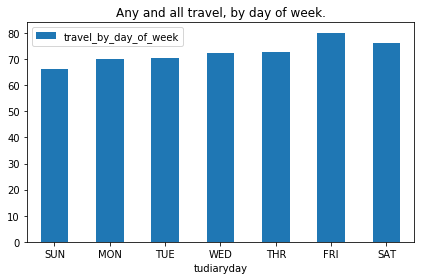

In [9]:
# ### How does travel, all_travel,  vary through the week?
# Using groupby to examine how weekly patterns show in the data.
# The output of a groupby is a series...

se_travel = df_sum.filter(items=['all_travel', 'tudiaryday']).groupby('tudiaryday')['all_travel'].mean()

#   WHY DID THESE MORE PYTHONESQUE WAYS FAIL? (merely trying to label bars with "Mon", "Tue" etc)
#df_travel['day_of_week'] = df_travel['tudiaryday'].apply(lambda x: day_names[x])
#df_travel['day_of_week'] = df_travel.apply(lambda x: day_names[x])
#df_travel['Col3'] = df_travel['index'].map(lambda x: day_names[x])

df_travel_reindexed = se_travel.reindex(['SUN', 'MON', 'TUE', 'WED', 'THR', 'FRI', 'SAT']).to_frame()
df_travel_reindexed['travel_by_day_of_week'] = list(se_travel)
df_travel_reindexed.plot(kind='bar', y='travel_by_day_of_week', 
                         title="Any and all travel, by day of week.", rot = 0)
plt.tight_layout()
plt.show()


I confess I'm surprised by how even this plot turns out to be.  
I assumed a strong weekly signal would be apparent, even in this data aggregated into "all_travel".  
More motivation of dive into details...  

In [10]:
codes_fp  = os.path.join(data_dir, 'codes.csv') 
df_codes = pd.read_csv(codes_fp)

def get_code_meaning(in_df=None, code=None):
    try:
        df_matches_with_nans = in_df.where(in_df['code'] == code)
        df_matches_no_nans = df_matches_with_nans.dropna(how='any')
        if len(df_matches_no_nans):
            meaning = df_matches_no_nans.iloc[0]['name']
            return meaning
        else:
            return None
    except IOError as e:
        print("get_code_meaning I/O error({0}): {1}".format(e.errno, e.strerror))

#print("\nProvide meaning to {0} codes listed in travel_18s\n".format(len(travel_18s)))
#for tcode in travel_18s:
#    code = int(tcode[1:])
#    meaning = get_code_meaning(in_df=df_codes, code=code)
#    print("{0:9} -> {1}".format(tcode, meaning))

### Ok, so now we have an easy means to meaning, lets pick a few specific reasons for trips...

#### Choose two expected to have weekdays/weekend relevence:  
  * 1) t181302   -> Travel related to attending sporting/recreational events
  * 2) t181401   -> Travel related to religious/spiritual practices

####  choose another expected to have time-of-day patterns:
  * 1) t181101   -> Travel related to eating and drinking

####  Choose another perhaps having gender influences:
  * 1)t180381   -> Travel related to caring for and helping hh children

Anticipating a similar "plot-per-week" for each of the above 4 travel codes,  
below is the function to do so, easily.  

<span style="color:green"> DRAFT @2  
In a loop of 4 activity codes, plot the per_week charts as sub plots  
for easier inter comparison for the reader.  
Near working code/pseudo code in next box.  
</span>


###  Objective 3)  Try to discern whether homes are closer to work or school  
(perhaps giving insight into housing market choices.)

I'll attack this question twice:
  * 1) First, just using the summary (respondent only data, but codes for both work and education travel)
  * 2) Second, merging with roster, who and respondents csv's, to confirm the household has kids.

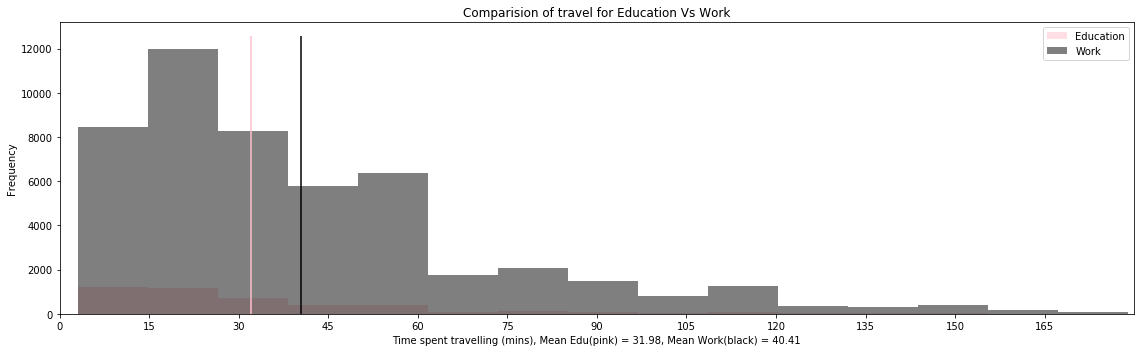

In [27]:
work_travel_codes = ['t180501', 't180502', 't180589']
edu_travel_codes = ['t180601', 't180699']

df_sum['travel_edu']  = df_sum[edu_travel_codes].sum(axis=1) 
df_sum['travel_work']  = df_sum[work_travel_codes].sum(axis=1)

df_sum['travel_edu']  = df_sum['travel_edu'].where(df_sum['travel_edu'] > 2).where(df_sum['travel_edu'] < 180).dropna()
df_sum['travel_work'] = df_sum['travel_work'].where(df_sum['travel_work'] > 2).where(df_sum['travel_work'] < 180).dropna()
df_compare_edu_work = df_sum[['travel_edu', 'travel_work']].dropna(how='all')
mean_edu = df_sum['travel_edu'].mean()
mean_work = df_sum['travel_work'].mean()

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 1, 1) 
df_compare_edu_work.plot(kind='hist', 
                         ax = ax1, 
                         bins=15, 
                         color = ['pink','black'],
                         alpha =0.5)
plt.title("Comparision of travel for Education (of Respondent) Vs Work")
plt.legend(["Education", "Work"])
plt.xlabel('Time spent travelling (mins), Mean Edu(pink) = {0:.2f}, Mean Work(black) = {1:.2f}'.format(mean_edu, mean_work))
plt.ylabel('Frequency')
plt.xlim([0, 180])
ymin, ymax = plt.ylim()
plt.xticks(range(0, 180, 15))
plt.vlines(mean_edu, 0, ymax, color='pink')
plt.vlines(mean_work, 0, ymax, color='black')
plt.tight_layout()
plt.show()

#df_compare_edu_work.plot(kind='hist',alpha=0.5)

In [4]:
# from all activities, keep just travel and a few columns as to who is travelling and why.
# Initially large files with much irrelevent data, filtered, and, smaller, re-written back to disk...
if (not os.path.exists(travel_act_fp)) or force_prune_activities_csv:
    df_act  = pd.read_csv(act_fp)
    # Filter rows to retain activities designated as "travel", for *ANY* reason. (coded 6 digits starting with 18)
    df_travel_act = df_act.where(df_act.trcodep.map(lambda x: x if (str(x).startswith('18')) else np.nan)).dropna()

    # Filter columns of un-need data
    keeper_act_cols = ['tucaseid', 'tuactivity_n', 'tucc5', 'tuactdur24', 'trcodep', 'tewhere', 'tufinlwgt']
    df_travel_act = df_travel_act.filter(items=keeper_act_cols)

    print("Filtered to retain *only* travel activities:")
    print("#rows    reduced from {0} to {1}".format(df_act.shape[0],df_travel_act.shape[0]))
    print("#columns reduced from {0} to {1}".format(df_act.shape[1],df_travel_act.shape[1]))
    print("writing out a csv file for *just* travel activities...")
    df_travel_act.to_csv(path_or_buf=travel_act_fp, mode = 'w', index=False)
else:
    df_travel_act = pd.read_csv(travel_act_fp)

In [5]:
# atuscps.csv file.  (CPS is the Current Population Survey. It's 625Mb)
if (not os.path.exists(travel_cps_fp)) or force_prune_cps_csv:
    df_cps  = pd.read_csv(cps_fp)
    keep_cps_col_linkers = ['tucaseid', 'tulineno']
    keep_cps_col_geog    = ['gestfips']         # gestfips = state
    keep_cps_occupation  = ['prdtocc1']                     # trdtocc1 = 22 = work in transportation
    keep_cps_school      = ['peschenr']                     # peschenr = 1 = enrolled in school

    all_cps_keepers  =  keep_cps_col_linkers + keep_cps_col_geog + keep_cps_occupation + keep_cps_school
    df_pruned_cps = df_cps.filter(items=all_cps_keepers)
    df_pruned_cps.to_csv(path_or_buf=travel_cps_fp, mode = 'w', index=False)
    print("#cps rows reduced from {0} to {1}".format(df_cps.shape[0],df_pruned_cps.shape[0]))
    print("#cps cols reduced from {0} to {1}".format(df_cps.shape[1],df_pruned_cps.shape[1]))
    print("writing out a csv file for cps data to help isolate, school run, commute and students...")
else:
    df_cps = pd.read_csv(travel_cps_fp)

In [6]:
if (not os.path.exists(travel_resp_fp)) or force_prune_resp_csv:
    df_resp  = pd.read_csv(resp_fp)
    big_df_resp_shape = df_resp.shape
    keep_resp_cols_linkers     = ['tucaseid', 'tulineno']               #for join/merge
    keep_resp_temporal         = ['tudiaryday', 'trholiday']            #for weekday/holiday exclusion
    keep_resp_cols_occ_ind_emp = ['trdtind1', 'trdtocc1', 'telfs']      #for taxi/bus driver exclusion
    keep_resp_cols_par_sch     = ['trnumhou', 'tryhhchild']             #for parent school run inclusion
    keep_resp_are_student      = ['teschenr']                           #for resp = school student inclusion

    all_resp_keepers =  keep_resp_cols_linkers +\
                        keep_resp_temporal +\
                        keep_resp_cols_occ_ind_emp +\
                        keep_resp_cols_par_sch +\
                        keep_resp_are_student

    df_resp = df_resp.filter(items=all_resp_keepers)
    df_resp.to_csv(path_or_buf=travel_resp_fp, mode = 'w', index=False)
    print("#cps rows reduced from {0} to {1}".format(big_df_resp_shape[0], df_resp.shape[0]))
    print("#cps cols reduced from {0} to {1}".format(big_df_resp_shape[1], df_resp.shape[1]))
    print("writing out a csv file for resp data")
else:
    df_resp = pd.read_csv(travel_resp_fp)

In [7]:
# Note that the activities dataframe (travel_act_df) still includes travel on weekends and holidays.
# The diarydate and whether a holiday is not in this activities data.
# It's recorded in the atusresp.csv
# We must now merge the "respondent" data.

In [8]:
# Before joining/merging, which columns in common in differnt csv files?
def get_cols_in_common(df1, df2):
    """Not very pandesque! Is there already a df method for this?"""
    df1_cols = list(df1.columns.values)
    df2_cols = list(df2.columns.values)
    overlap = list(set(df1_cols).intersection(df2))
    return overlap
print(get_cols_in_common(df_travel_act, df_resp))

['tucaseid']


In [9]:
df_merged_act_resp = pd.merge(df_travel_act, df_resp, on=['tucaseid'], how='outer')
print(df_merged_act_resp.shape)

(701526, 15)


In [10]:
# NB. weekdays are encoded such that  (1,2,3 -> 7)  == (Sun, Mon, Tue -> Sat)
# Query for: non-sundays AND non-saturdays AND non-holidays
weekday_travel_df = df_merged_act_resp.query('(tudiaryday != 7) & (tudiaryday != 1) & (trholiday == 0)').dropna(how='all')

In [11]:
# Reading the remaining needed data
#df_sum  = pd.read_csv(sum_fp)
df_rost = pd.read_csv(rost_fp)
df_who  = pd.read_csv(who_fp)

In [16]:
#Merging.  Roster and Who  ... then that result into the above "weekday_travel_act_resp_df"
print(get_cols_in_common(df_rost, df_who))
df_merged_rost_who = pd.merge(df_rost, df_who, on=['tucaseid', 'tulineno'], how='outer')
print(df_merged_rost_who.shape)

print(get_cols_in_common(weekday_travel_df, df_merged_rost_who))
df_merged_all = pd.merge(weekday_travel_df, df_merged_rost_who, on=['tucaseid', 'tulineno', 'tuactivity_n'], how='outer')
df_merged_all.to_csv(path_or_buf=travel_all_fp, mode = 'w', index=False)
df_merged_all.shape

['tucaseid', 'tulineno']
(4393901, 8)
['tucaseid', 'tulineno', 'tuactivity_n']


(4548557, 20)

In [17]:
# 3 population isolation efforts are needed and will follow below:
#         1) Those parent respondents driving their student child to school.
#         2) Those parent respondents, without child drop-off, commuting to work, who don't work in transport.
#         3) Those high-schoolers/student respondents who are self-driving to/from school/college.

In [18]:
# The is to allow jumping in mid-way.
#data_dir= '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/'
#travel_all_fp   = os.path.join(data_dir, 'tw_atus_travel_all.csv')
#df_merged_all = pd.read_csv(travel_all_fp)
#rint(df_merged_all.shape)
#print(df_merged_all.memory_usage(index=True).sum()/1000000)

3 population isolation efforts are needed and will follow below:  
        1) Those parent respondents driving under 13 student to school.  
        2) Those parent respondents, without child drop-off, commuting to work, who don't work in transport.  
        3) Those high-schoolers/student respondents who are self-driving to/from school/college.

In [19]:
# LEGEND:
# trcodep activity codes 180601 and 180699 are travel for "taking class" and "education n.e.c."
# tucc5 is +'ve is child under 13 present
# tewhere's transport are: 12,13:car driver,pass, 14:walk, 15:Bus, 14:train, 20:plane, 21 other.
# terrp is "relationship to resp" & 22,23,27 are own,grand and foster child (18,19 = self = rest)
# tulineno 1=resp alone, 2= first companion etc.
# trdtocc1 "occupation" = 22 = "transportation"
# telfs  "full or part-time employment status" = 1:employed, all others not.

In [20]:
df_has_company = df_merged_all.where(df_merged_all['tulineno'] > 1).dropna(how='all')
print(df_has_company.shape)

df_has_kid_co  = df_has_company.where(df_has_company['terrp'] == 22).dropna(how='all')
print(df_has_kid_co.shape)

df_has_kid_in_car = df_has_kid_co.where(df_has_kid_co['tewhere'] == 12).dropna(how='all')
print(df_has_kid_in_car.shape)

print("\nThis is not working the way I expected! No own children being driven! \n")

(1810563, 20)
(1001417, 20)
(0, 20)

This is not working the way I expected! No own children being driven! 



In [21]:
# The filter chain below... Respondent has company -> of own child -> in the car
print(df_merged_all.query('tulineno > 1').dropna(how='all').shape)
print(df_merged_all.query('tulineno > 1').query('terrp == 22').dropna(how='all').shape)
print(df_merged_all.query('tulineno > 1').query('terrp == 22').query('tewhere == 12').dropna(how='all').shape)
print("\nSame way to same wrong daft result.\n")

(1810563, 20)
(1001417, 20)
(0, 20)

Same way to same wrong daft result.



In [22]:
# Flogging this dead-cat...
# tucc5 > 1 if in company of own child under 13
print(df_merged_all.query('tucc5 > 1').dropna(how='all').shape)
print(df_merged_all.query('tucc5 > 1').query('terrp == 22').dropna(how='all').shape)

print("\nI.E. Of the 1156 under 13 year olds with the respondent, 0 also the their own! I don't get it!\n")

(1156, 20)
(0, 20)

I.E. Of the 1156 under 13 year olds with the respondent, 0 also the their own! I don't get it!



In [ ]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 1, 1)            # Create first  matplotlib axes
travel_with_under_13_df['tuactdur24'].plot(kind='hist',  ax = ax1, bins=90)
plt.title('Travel with a child under 13.')    
#plt.xlabel("Time spent travelling (mins)\nAverage = {0:.0f} (some don't travel at all)".format(travel_mean))
plt.xlabel("Time spent travelling (mins)")
plt.ylabel('Frequency of respondents travelling this time.')
plt.xlim([0, 90])
ymin, ymax = plt.ylim()
#plt.xticks(range(0, 600, 60))
#plt.vlines(travel_mean, 0, ymax, color='red')

In [ ]:
#df_rost.groupby('tucaseid').where(df_rost['tulineno'].max > 1)
# terrp (relationship) corresponds 22, 23, 27, 40 = own, grand, foster, non-hh yet own child

def has_child(x):
    if x in [22,23,27,40]:
        return 1
    else:
        return 0

#hh_non_solo = df_rost.groupby('tucaseid')['tulineno'].max()
#hh_with_child = df_rost.groupby('tucaseid').apply(has_child(df_rost['terrp']))                                                 
#hh_with_child

In [ ]:
# Summing across columns ( hence: axis = 1) all those named in the list: travel_18s
df_sum['all_travel'] = df_sum[travel_18s].sum(axis=1)
all_edu_travel_df  = df_sum[['t180601', 't180699']]


# The average time spent traveling by Americans:
all_travelling_any_reason = df_sum['all_travel'].sum()
all_travellers = df_sum['all_travel'].count()
mean_travel_any_reason = round(all_travelling_any_reason / all_travellers)
in_hours = mean_travel_any_reason/60
print("\nAverage time Americans spend traveling = {0:.0f} mins".format(mean_travel_any_reason))
print("(ie {0:.2f} hours ... Travelling for any reason.)\n".format(in_hours))

In [ ]:
def average_minutes(data, activity_code):
    activity_col = "t{}".format(activity_code)
    data = data[['TUFINLWGT', activity_col]]
    data = data.rename(columns={"TUFINLWGT": "weight", activity_col: "minutes"})
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()

def average_minutes2(data, activity_code):
    cols = activity_columns(data, activity_code)
    activity_data = data[cols]
    activity_sums = activity_data.sum(axis=1)
    data = data[['TUFINLWGT']]
    data['minutes'] = activity_sums
    data = data.rename(columns={"TUFINLWGT": "weight"})
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()